In [1]:
#Run this cell if any import errors occur
#! pip install datasets transformers
#! pip install -U scikit-learn

In [2]:
#Collecting all imports
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
from sklearn.metrics import f1_score
import numpy as np

import transformers

print(transformers.__version__)
#Transformers should be at least 4.11.0 required!

4.36.2


We must now load the dataset from our local JSON files. 

In [3]:
#Load the dataset as train, validation, and test.
#We use the dev data as validation.

datasets = load_dataset("json", data_files={'train':'Project/QQA_Data/QQA_train.json', 
                                           'validation':'Project/QQA_Data/QQA_dev.json', 
                                           'test':'Project/QQA_Data/QQA_test.json'})

#Printing the dataset contents
print('Q: ' + datasets['train'][0]['question'])
print('O1: ' + datasets['train'][0]['Option1'])
print('O2: ' + datasets['train'][0]['Option2'])
print('A: ' + datasets['train'][0]['answer'])

print(datasets)

print(len(datasets))

Q: The ranger and the rustler both were riding horses that galloped at the same speed.  The rustler left at 01:00 where as the ranger left at 0500 hours. Who has traveled further?? 
O1: the ranger
O2: the rustler
A: Option 2
DatasetDict({
    train: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 564
    })
    validation: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 81
    })
    test: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 162
    })
})
3


In [4]:
#Print dataset structure
datasets

DatasetDict({
    train: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 564
    })
    validation: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 81
    })
    test: Dataset({
        features: ['question_mask', 'Option2', 'question_sci_10E_char', 'question_sci_10E', 'answer', 'question', 'question_char', 'Option1', 'type'],
        num_rows: 162
    })
})

The imported data is of the form:

{"question": "Jame's mother has a photo of Jane standing at a height of 14 inches, whereas a mountain appears to have height of 26 cm. It looks that way because? ", "Option1": "the mountain was farther away", "Option2": "Jane was farther away", "answer": "Option 2", "type": "Type_3", "question_sci_10E": "Jame's mother has a photo of Jane standing at a height of 1.4000000000E+01 inches, whereas a mountain appears to have height of 2.6000000000E+01 cm. It looks that way because? ", "question_char": "Jame's mother has a photo of Jane standing at a height of 1 4 inches, whereas a mountain appears to have height of 2 6 cm. It looks that way because? ", "question_sci_10E_char": "Jame's mother has a photo of Jane standing at a height of 1 . 4 0 0 0 0 0 0 0 0 0 E + 0 1 inches, whereas a mountain appears to have height of 2 . 6 0 0 0 0 0 0 0 0 0 E + 0 1 cm. It looks that way because? ", "question_mask": "Jame's mother has a photo of Jane standing at a height of [Num] inches, whereas a mountain appears to have height of [Num] cm. It looks that way because? "

In [5]:
#Let's get rid of the other columns
datasets = datasets.remove_columns(['question_char', 'question_sci_10E',
                         'question_sci_10E_char',
                         'question_mask', 'type',])

#We now only have a question, answer, and 2 options.

In [6]:
#Renaming for compatibility later
datasets = datasets.rename_column('answer', 'label')

For evaluation, see https://huggingface.co/spaces/evaluate-metric/accuracy

For fine-tuning, see: https://huggingface.co/docs/transformers/en/training#train-with-pytorch-trainer

For handing multiple choice, see https://huggingface.co/docs/transformers/en/tasks/multiple_choice


In [7]:
#Set correct answer to an integer. 

def set_labels(example):
    #print(example)
    example["label"] = int(example["label"][-1]) - 1
    return example

datasets = datasets.map(set_labels)

In [8]:
datasets["train"][30]

{'Option2': 'pickup',
 'label': 1,
 'question': 'A race car and a pickup both drove on the highway at the same speed. The driver of the race car got tired and parked after 29 mins, while the driver of the pickup ran for 43 mins. Which vehicle ultimately went the greater distance?? ',
 'Option1': 'race car'}

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
tokenizer("This is a boat.", "This is a plane.")

{'input_ids': [101, 2023, 2003, 1037, 4049, 1012, 102, 2023, 2003, 1037, 4946, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
ending_names = ["Option1", "Option2"]

def preprocess_function(examples):
    # Repeat each first sentence two times to go with the two possibilities of second sentences.
    first_sentences = [[context] * 2 for context in examples["question"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["question"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]
    
    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    # Un-flatten
    return {k: [v[i:i+2] for i in range(0, len(v), 2)] for k, v in tokenized_examples.items()}

In [11]:
examples = datasets["train"][:5]
features = preprocess_function(examples)
print(len(features["input_ids"]), len(features["input_ids"][0]), [len(x) for x in features["input_ids"][0]])

5 2 [89, 90]


In [12]:
idx = 3
[tokenizer.decode(features["input_ids"][idx][i]) for i in range(2)]

['[CLS] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? [SEP] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? the tank will speed up faster than the toy car [SEP]',
 '[CLS] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? [SEP] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? the toy car will speed up faster than the tank [SEP]']

In [13]:
#encoded_datasets = datasets.map(preprocess_function, batched=True)
#print(encoded_datasets)

In [14]:
model = AutoModelForMultipleChoice.from_pretrained('bert-base-uncased')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [16]:
#Testing stuff. Be sure to create encoded_datasets if you're running this. 
#accepted_keys = ["input_ids", "attention_mask", "label"]
#features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
#batch = DataCollatorForMultipleChoice(tokenizer)(features)
#[tokenizer.decode(batch["input_ids"][8][i].tolist()) for i in range(2)]

In [17]:
#Use the F1 score metric to evaluate our predictions. 

#Old evaluator.
'''
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}
'''

#New evaluator.
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    
    preds = np.argmax(predictions, axis=1)

    return {"accuracy": f1_score(label_ids, preds, average='micro')}

In [18]:
# A cell to reset the dataset if/when problems occur with it.
# Probably good to run this if you ran the above cells, since there's a lot of testing stuff for one model

datasets = load_dataset("json", data_files={'train':'Project/QQA_Data/QQA_train.json', 
                                           'validation':'Project/QQA_Data/QQA_dev.json', 
                                           'test':'Project/QQA_Data/QQA_test.json'})

#Printing the dataset contents
print('Q: ' + datasets['train'][0]['question'])
print('O1: ' + datasets['train'][0]['Option1'])
print('O2: ' + datasets['train'][0]['Option2'])
print('A: ' + datasets['train'][0]['answer'])

#Let's get rid of the other columns
datasets = datasets.remove_columns(['question_char', 'question_sci_10E',
                         'question_sci_10E_char',
                         'question_mask', 'type',])

#We now only have a question, answer, and 2 options.

datasets = datasets.rename_column('answer', 'label')

def set_labels(example):
    #print(example)
    example["label"] = int(example["label"][-1]) - 1
    return example

datasets = datasets.map(set_labels)

print(datasets)

Q: The ranger and the rustler both were riding horses that galloped at the same speed.  The rustler left at 01:00 where as the ranger left at 0500 hours. Who has traveled further?? 
O1: the ranger
O2: the rustler
A: Option 2
DatasetDict({
    train: Dataset({
        features: ['Option2', 'label', 'question', 'Option1'],
        num_rows: 564
    })
    validation: Dataset({
        features: ['Option2', 'label', 'question', 'Option1'],
        num_rows: 81
    })
    test: Dataset({
        features: ['Option2', 'label', 'question', 'Option1'],
        num_rows: 162
    })
})


In [19]:
#Training function. Duplicate and change model name for other models.

modelName = ""

def autoTrain(model_name = 'bert-base-uncased', batch_size = 16):
    global model
    global tokenizer
    global modelName
    modelName = model_name
    model = AutoModelForMultipleChoice.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    
    encoded_datasets = datasets.map(preprocess_function, batched=True)
    
    args = TrainingArguments(
        f"{model_name}-finetuned-QQA",
        evaluation_strategy = "epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=3,
        weight_decay=0.01,
    )
    
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_datasets["train"],
        eval_dataset=encoded_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )
    
    trainer.train()

In [20]:
#Cell for testing
print(datasets["test"])

Dataset({
    features: ['Option2', 'label', 'question', 'Option1'],
    num_rows: 162
})


In [21]:
# Example prediction

prompt = "I have 5 bagels and Joe has 2. Who has more bagels?"
candidate1 = "Me"
candidate2 = "Joe"


inputs = tokenizer([[prompt, candidate1], [prompt, candidate2]], return_tensors="pt", padding=True)
labels = torch.tensor(0).unsqueeze(0)
outputs = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
logits = outputs.logits

predicted_class = logits.argmax().item()
predicted_class

#Note that it will output a 0 or 1, where 0 = Option 1 and 1 = Option 2

0

In [22]:
#Eval the most recently trained model
def evaluate_hf_model():

    global model
    global tokenizer

            
    predictions = []
    references = []

    # Get predictions, and save corresponding reference (if we were using the whole dataset, we wouldn't need this step)
    for ex in datasets["test"]:

        #Based on the above cell, get 
        prompt = ex['question']
        candidate1 = ex['Option1']
        candidate2 = ex['Option2']
        
        inputs = tokenizer([[prompt, candidate1], [prompt, candidate2]], return_tensors="pt", padding=True)
        labels = torch.tensor(0).unsqueeze(0)
        outputs = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
        logits = outputs.logits
        
        predicted_class = logits.argmax().item()
        predicted_class


        predictions.append(predicted_class)
        references.append(ex['label'])

    # Compute metrics
    global modelName
    print('Performance of {} : {}'.format(modelName, f1_score(references, predictions, average='micro')))

In [23]:
def trainAndEval(model_name, batch_size):
    autoTrain(model_name, batch_size)
    #eval_hf_model evaluates whatever model we just trained because of global variables. 
    #As such we have it eval after training.
    evaluate_hf_model()

In [24]:
#Training and evaluating bert-base-uncased
trainAndEval("bert-base-uncased", 16)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693164,0.493827
2,No log,0.692938,0.567901
3,No log,0.692991,0.481481


Performance of bert-base-uncased : 0.5123456790123457


In [25]:
trainAndEval("distilbert/distilbert-base-uncased", 16)

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693390,0.456790
2,No log,0.694269,0.382716
3,No log,0.695582,0.370370


Performance of distilbert/distilbert-base-uncased : 0.4876543209876543


In [25]:
trainAndEval("dccuchile/bert-base-spanish-wwm-cased", 16)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.weight', 'bert.pooler.dense.bias', 'classifier.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693188,0.407407
2,No log,0.693684,0.358025
3,No log,0.693626,0.395062


Performance of dccuchile/bert-base-spanish-wwm-cased : 0.5370370370370371


In [24]:
trainAndEval('deepset/roberta-base-squad2', 16)

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'classifier.bias', 'roberta.pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.694425,0.481481
2,No log,0.692649,0.580247
3,No log,0.691565,0.592593


Performance of deepset/roberta-base-squad2 : 0.5246913580246914


In [25]:
trainAndEval('Intel/dynamic_tinybert', 16)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at Intel/dynamic_tinybert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693222,0.530864
2,No log,0.693265,0.530864
3,No log,0.693292,0.530864


Performance of Intel/dynamic_tinybert : 0.5308641975308642


In [ ]:
trainAndEval('distilbert/distilbert-base-uncased-distilled-squad', 16)

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert/distilbert-base-uncased-distilled-squad and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/Users/patrick/opt/anaconda3/envs/NLP/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


In [ ]:
trainAndEval('distilbert/distilbert-base-cased-distilled-squad', 16)

In [ ]:
trainAndEval("cardiffnlp/twitter-roberta-base-sentiment-latest", 16)

In [ ]:
trainAndEval("MilaNLProc/feel-it-italian-sentiment", 16)

In [ ]:
trainAndEval('RashidNLP/Finance-Sentiment-Classification', 16)

In [ ]:
trainAndEval('juliensimon/reviews-sentiment-analysis', 16)

In [ ]:
trainAndEval("google/rembert", 16)

In [ ]:
trainAndEval("mnaylor/mega-base-wikitext", 16)

In [ ]:
trainAndEval("allenai/longformer-base-4096", 16)

# Comparison:

The models that we evaluated were the following:

Baseline:

The baseline model, bert-base-uncased, and its variants. Most are designed for masked langauge modeling with similar training data, so that the only major differences are the architecture of the transformer. Some, however, use different training data. 

- bert-base-uncased, trained on a large corpus of unlabeled data with the objective of masked language modeling and next sentence prediction. Because there are no "special" features in this version of BERT, and because of its ubiquity, it is used as a baseline for other models to be compared to in this project. https://huggingface.co/google-bert/bert-base-uncased
- distilbert-base-uncased, trained on the same data as the regular bert-base-uncased. It is smaller and faster than regular BERT, and provides an example of how reducing the number of parameters (from 110M to 67M) affects a model's ability to preform QQA. Notably, distilbert trained faster, at 0.18 it/s instead of the regular BERT's 0.08 it/s. https://huggingface.co/distilbert/distilbert-base-uncased (in progress)
- bert-base-spanish-wwm-cased, trained on a large corpus of Spanish data. Used as an example of how training data may affect a model's ability to preform QQA. https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased (in progress)

SQuAD:

Modeles trained in SQUAD, a labelled dataset containing questions and answers drawn from the questions. Unlike the basic BERT model, these models have been trained/fine-tuned on labelled data. 

- Roberta-base-squad2, a version of RoBERTA trained on labeled data (in this case, the SQUAD dataset). As labeled data contains questions and answers, and our QQA task is fundamentally question-answering, it should affect the ability of the model to preform QQA. https://huggingface.co/deepset/roberta-base-squad2 (In progress)
- Dynamic-Tinybert, an even smaller version of BERT fine-tuned for the task of question answering. It will serve to show how decreasing a model's size with pretrained data can affects its QQA ability.  https://huggingface.co/Intel/dynamic_tinybert (In progress)
- distilbert-base-uncased-distilled-squad, a distilbert variant that serves mostly as something to be compared to the cased variant and non-squad variant. When compared to the non-finetuned variant, it demonstrates how being fine-tuned on labelled data affects the same model's QQA ability. https://huggingface.co/distilbert/distilbert-base-uncased
- distilbert-base-cased-distilled-squad, a cased version of distilbert fine-tuned on distilled SQUAD data. It mostly shows how being a cased model affects its preformance compared to the uncased model above. https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad (In progress)

Sentiment Analysis Models:

Models designed for sentiment analysis. 

- cardiffnlp/twitter-roberta-base-sentiment-latest, a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark. As this is trained for sentiment analysis, it'll provide insight into how being fine-tuned for another task beforehand affects a model's ability to preform QQA. It will also serve as the baseline for the sentiment analysis models as it contains no other notable features.
- feel-it-italian-sentiment, a sentiment analysis model trained on foreign language data (in this case, Italian). Serves mostly as a metric on how foreign languages affect a basic sentiment analysis model's ability to preform QQA. feel-it was trained on Italian tweets that were annotated. https://huggingface.co/MilaNLProc/feel-it-italian-sentiment (In progress)
- Finance-Sentiment-Classification, a deBERTa variant trained to find sentiment in financial contexts. As a lot of financial data contains numbers, this serves as insight into how training data with numerical components affects a model's ability to preform QQA. https://huggingface.co/RashidNLP/Finance-Sentiment-Classification (in progress)
- reviews-sentiment-analysis, a model based on analyzing the sentiment of customer reviews. This serves to provide insight into how different training data can affect a model's ability to preform QQA compared to tweets. https://huggingface.co/juliensimon/reviews-sentiment-analysis?library=true (in progress)

Intensive Memory Handling Models:

- google/rembert: RemBERT is a specialized variant of the BERT model that is tailored specifically for memory-intensive tasks. The name "RemBERT" stands for "Reformer with Memory," indicating its reliance on the Reformer architecture, which is known for its ability to efficiently process long sequences. The Reformer architecture employs techniques such as locality-sensitive hashing (LSH) and reversible residual layers to reduce memory consumption while preserving performance. RemBERT can be particularly useful for tasks involving long documents or sequences, such as document classification, long-form question answering, and text generation. By accommodating longer input sequences, RemBERT expands the range of applications where BERT-based models can be effectively employed. Our data does not involve very long sequences so it should theorhetically preform similarly to other models not desiged for this purpose. https://huggingface.co/google/rembert (in progress)
- mnaylor/mega-base-wikitext: MEGA presents a novel approach to self-attention in neural network architectures. Unlike traditional Transformers, MEGA incorporates a multi-headed exponential moving average alongside standard dot-product attention within each encoder layer. This design choice enhances the model's performance on standard benchmarks while maintaining significantly fewer parameters. MEGA's computational efficiency enables it to effectively handle long sequences, making it well-suited for tasks involving lengthy documents in natural language processing. https://huggingface.co/mnaylor/mega-base-wikitext (in progress)
- allenai/longformer-base-4096: Longformer employs an attention mechanism that scales linearly with sequence length, enabling efficient processing of documents containing thousands of tokens. Additionally, Longformer outperforms RoBERTa on long document tasks and achieves new state-of-the-art results on tasks like WikiHop and TriviaQA when pretrained and fine-tuned. By leveraging sparse attention matrices, Longformer significantly reduces memory and time complexity, making it suitable for processing extensive textual data efficiently. https://huggingface.co/allenai/longformer-base-4096 (in progress)



All models were fine-tuned on the QQA train and validation datasets for 3 epochs with a batch size of 16, and evaluated using the custom evaluate_hf_model() function afterward. This function loops through each item in the QQA test split, receives a prediction from the model, and extracts the reference label from the dataset. Both a list of predictions and references are used as inputs for the scikit micro-F1 score for evaluation.

In [26]:
#Storing the name and accuracy as a listto avoid having to re-run training and evaluation functions, saving computing power. 
#Names are shortened to be readable on the graphs.

#Matplotlib.pyplot is imported seperately so that adjusting graphs can be done without importing large amounts of other modules

import matplotlib.pyplot as plt 

modelNameAcc = [
    #Baseline, masked language
    ["bert", 0.5123456790123457],
    ["distilbert", 0.4876543209876543],    
    ["bert-base-spanish", 0.5370370370370371],
    
    #Squad
    ['base-squad2', 0.5246913580246914],
    ["dynamic-tinybert", 0.5308641975308642], 
    #Re-evaluate the below! (move this comment down as we finish re-evaluating)

    ['distilbert-cased', 0],
    ['distilbert-uncased', 0],
    
    #Sentiment Analysis
    ["twitter-roberta", 0],
    ['feel-it-italian-sentiment', 0],
    ['finance-sentiment-classification', 0],
    ['reviews-sentiment-analysis', 0],

    #Memory-based
    ['rembert', 0],
    ['mega', 0],
    ['longformer', 0]



]

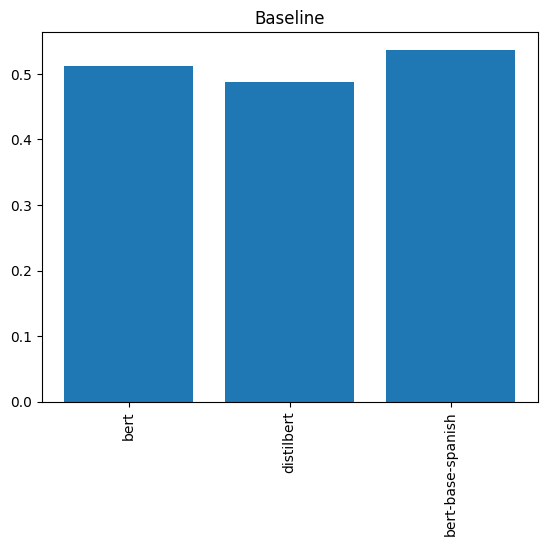

In [27]:
#Plot model names, accuracies, on a graph for easy comparison

#X points for plotting
xpoints = np.linspace(1, len(modelNameAcc), len(modelNameAcc))
ypoints = np.zeros(len(modelNameAcc))

countModels = 0
names = []
for k in range(len(modelNameAcc)):
    model, acc = modelNameAcc[k]
    countModels += 1
    ypoints[k] = acc
    names.append(model)

#Set plot and plot
plt.title("Baseline")
plt.xticks(xpoints[0:3], names[0:3], rotation = 'vertical')
plt.bar(xpoints[0:3], ypoints[0:3])
plt.show()

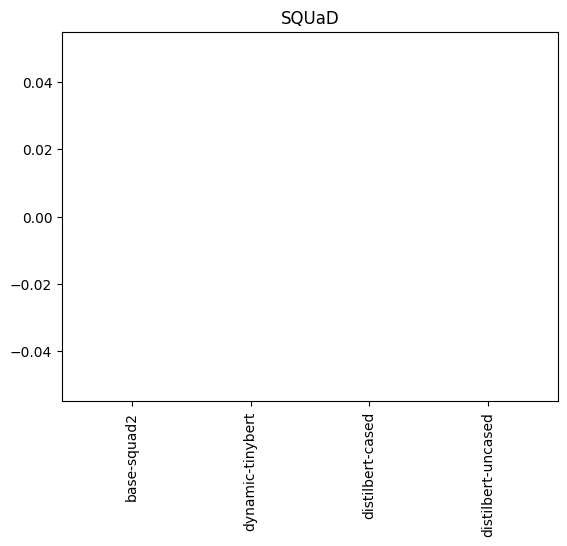

In [28]:
#Set plot and plot
plt.title("SQUaD")
plt.xticks(xpoints[3:7], names[3:7], rotation = 'vertical')
plt.bar(xpoints[3:7], ypoints[3:7])
plt.show()

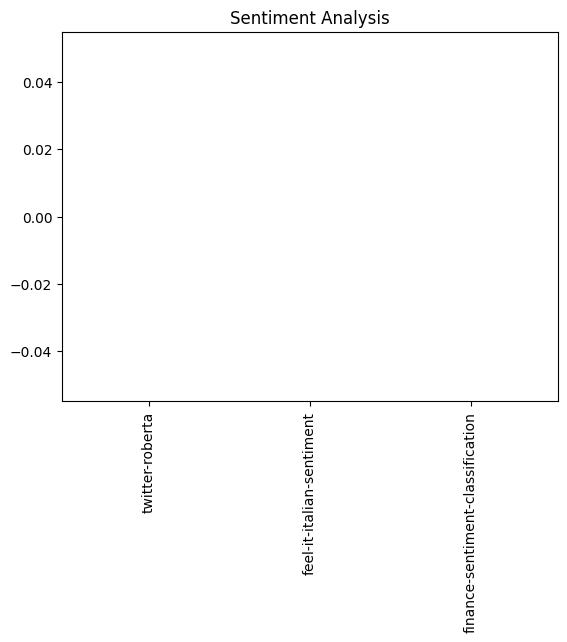

In [29]:
#Set plot and plot
plt.title("Sentiment Analysis")
plt.xticks(xpoints[7:10], names[7:10], rotation = 'vertical')
plt.bar(xpoints[7:10], ypoints[7:10])
plt.show()

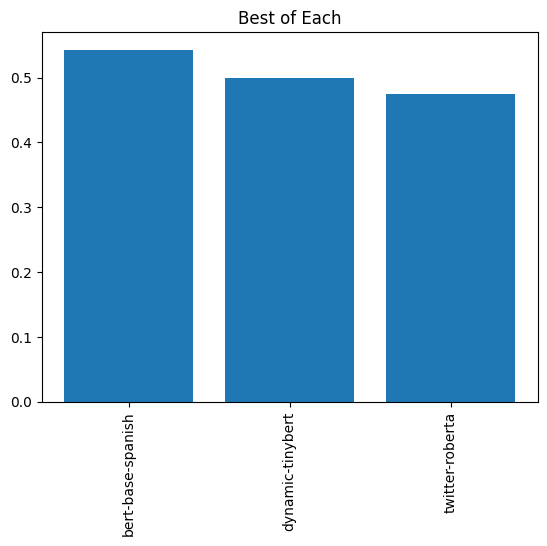

In [30]:
best = [
    #Baseline, masked language
    ["bert-base-spanish", 0.5432098765432098],

    #Squad
    ["dynamic-tinybert", 0.5], 
    
    #Sentiment Analysis
    ["twitter-roberta", 0.47530864197530864],
]

#X points for plotting
xpoints1 = np.linspace(1, len(best), len(best))
ypoints1 = np.zeros(len(best))

countModels1 = 0
names1 = []
for k in range(len(best)):
    model, acc = best[k]
    countModels += 1
    ypoints1[k] = acc
    names1.append(model)

#Set plot and plot
plt.title("Best of Each")
plt.xticks(xpoints1, names1, rotation = 'vertical')
plt.bar(xpoints1, ypoints1)
plt.show()

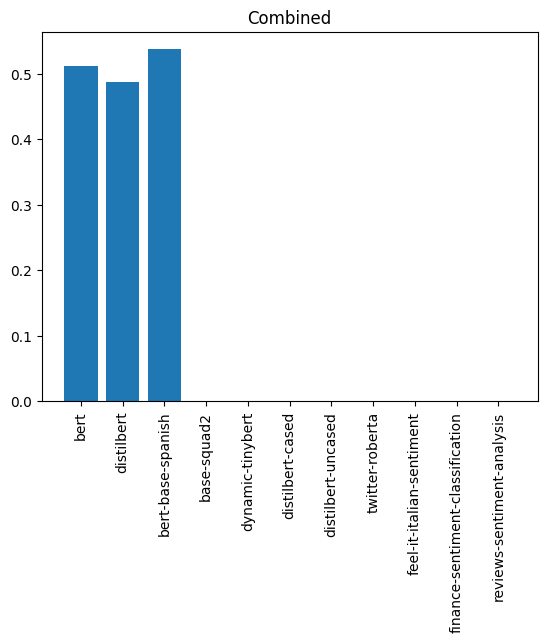

In [31]:
plt.title("Combined")
plt.xticks(xpoints, names, rotation = 'vertical')
plt.bar(xpoints, ypoints)
plt.show()